### Загрузка библиотек

In [14]:
import pandas as pd
import numpy as np
# import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

In [15]:
df = pd.read_csv('data.csv')
df_orig = pd.read_csv('data.csv')

In [16]:
# file_path_csv = 'df(2).csv'
# file_path_excel = 'df.xlsx'

# df = pd.read_csv(file_path_csv)

# df.to_excel(file_path_excel, index=False)

### Подготовка данных

In [17]:
missing_values = df.isnull().sum()
unique_values = df.nunique()
type_values = df.dtypes

missing_values_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Unique Values': unique_values,
    'Type Values': type_values
})

missing_values_summary


,Missing Values,Unique Values,Type Values
Вектор Мощи,0,9,float64
Скорость перехода через портал,0,9,float64
Приток Силы Потока,0,11430,float64
Ритм магического ядра,0,3888,float64
Поток Энергий,0,11834,float64
Сила Левого Потока,0,4286,float64
Сила Правого Потока,0,4286,float64
Пламя Стихий,0,11772,float64
Температура вдоха Истока,0,1,int64
Температура выдоха Истока,0,2369,object


Пропусков нет, это хорошо, но несколько значений object, что не подходит для моделирования (текстовые значения) -> Избавимся от этих значений

In [18]:
df['Температура выдоха Истока'] = pd.to_numeric(df['Температура выдоха Истока'], errors='coerce')
df['Древний Ветер'] = pd.to_numeric(df['Древний Ветер'], errors='coerce')

### Выполнение рекомендаций

In [19]:
df['Полная сила потока'] = df['Сила Левого Потока'] + df['Сила Правого Потока']
df['Более полная сила потока'] = df['Полная сила потока'] + df['Приток Силы Потока']
df['Общая сила ядра'] = df['Ритм магического ядра'] * df['Приток Силы Потока']
df['Общее давление на выходе'] = df['Приток давления Выдоха Истока'] + df['Давление выдоха Истока']
df['Магическая производительность'] = df['Скорость перехода через портал'] / (df['Эмульсия Истока'] + 1e-10)
df['Эффективность ядра'] = df['Общая сила ядра'] / (df['Эмульсия Истока'] + 1e-10)
df['Магическая мощность'] = df['Эмульсия Истока'] * df['Общее давление на выходе'] * (df['Пламя Стихий'] - df['Температура вдоха Истока'])
df['Степень износа'] = df['Дыхание Истока'] / (df['Гармония Бессмертия'] + 1e-10)
df['Расхождение в стабильности магии'] = abs(df['Дыхание Истока'] - df['Гармония Бессмертия'])
df['Баланс угасания магии'] = df['Расхождение в стабильности магии'] / (df['Скорость перехода через портал'] + 1e-10)

### Корреляционная матрица

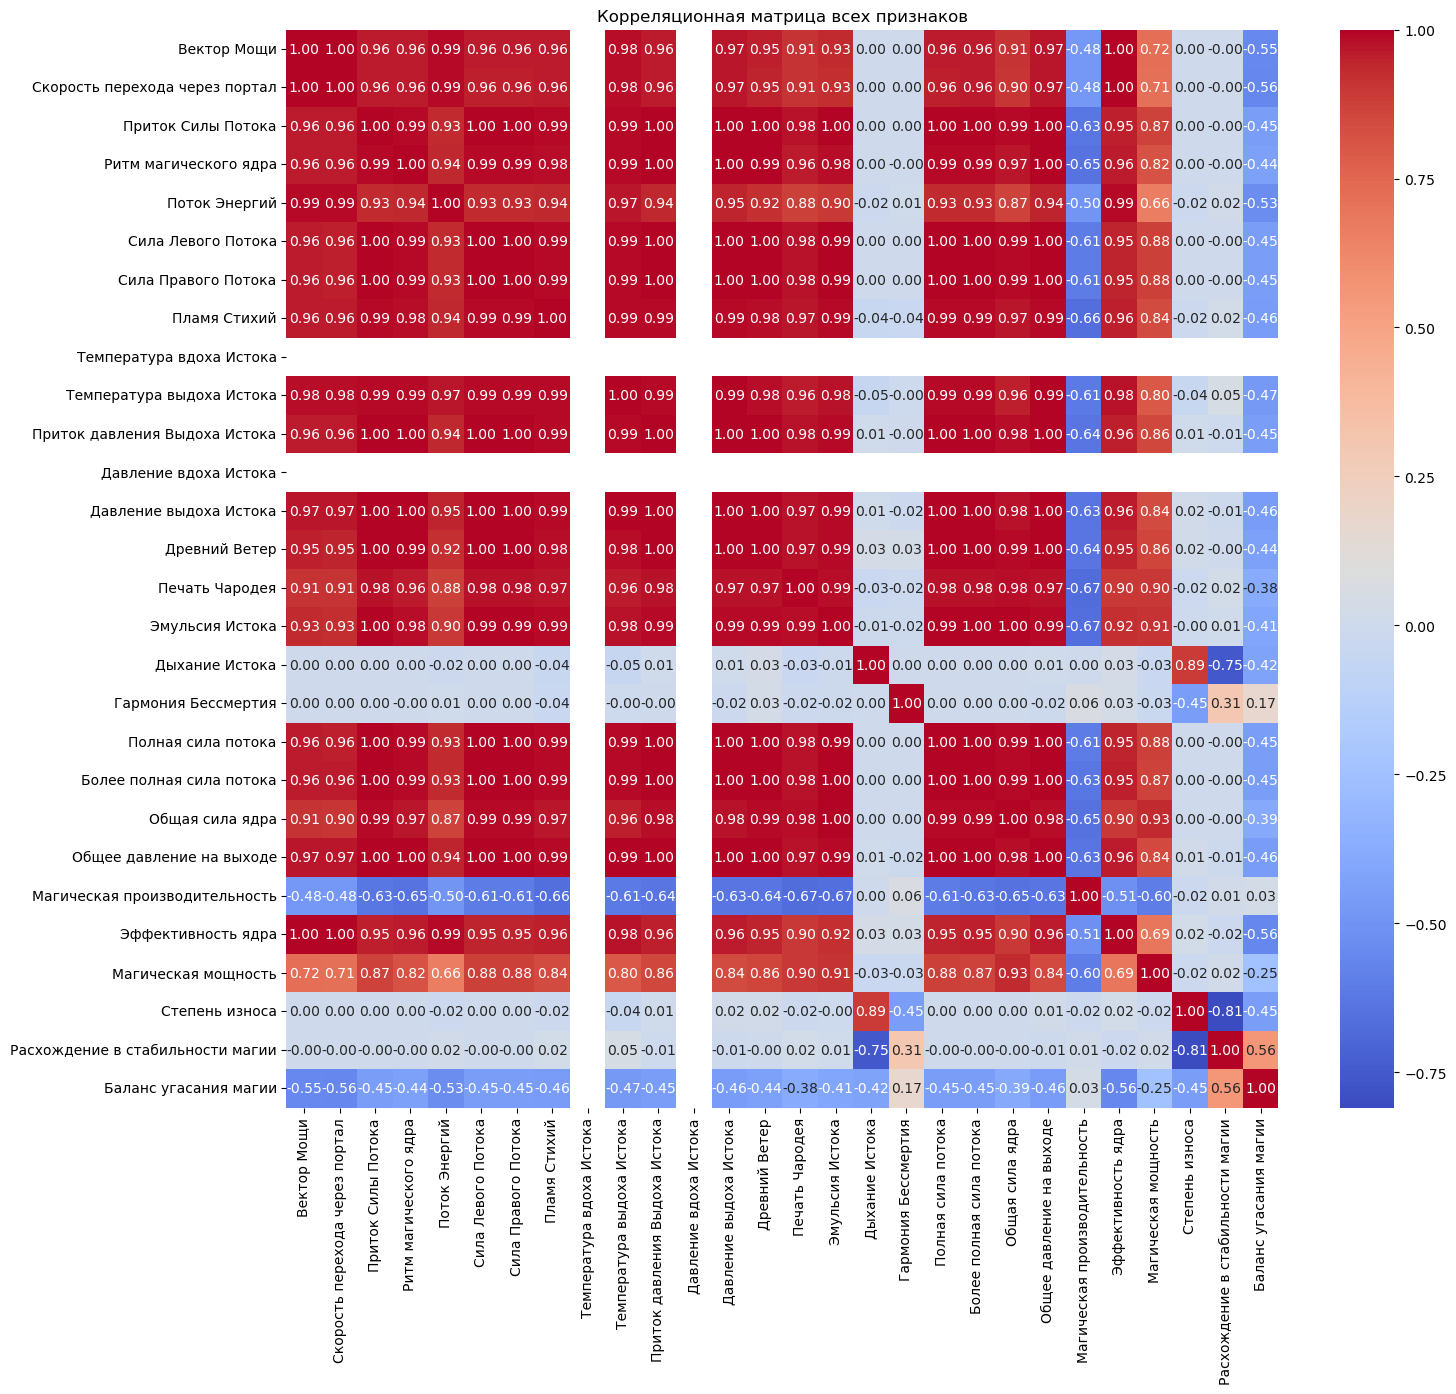

In [20]:
plt.figure(figsize=(16, 14))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Корреляционная матрица всех признаков")
plt.show()

Эта матрица позволяет нам оценить, как параметры влияют друг на друга, что я буду использовать для дайльнейшего определения какие признаки убрать или добавить

### Новые признаки

In [21]:
# df['ΔДавления'] = df['Давление выдоха Истока'] - df['Давление вдоха Истока']  # Разница давлений; отражает прирост давления в системе, влияющий на стабильность портала
# df['Энергетическая эффективность'] = df['Магическая мощность'] / (df['Эмульсия Истока'] * df['Пламя Стихий'] + 1e-10)  # Эффективность преобразования топлива и температуры в магическую мощность
# df['Стресс магического ядра'] = df['Ритм магического ядра'] * df['ΔДавления']  # Комбинированная нагрузка на ядро; высокие значения могут указывать на риск отказа
# df['Удельная магическая мощность'] = df['Магическая мощность'] / (df['Более полная сила потока'] + 1e-10)  # Эффективность генерации магической мощности на единицу суммарного потока
# df['Загрузка магического ядра'] = df['Ритм магического ядра'] / df['Ритм магического ядра'].max()  # Текущая нагрузка ядра относительно его максимальной мощности
# df['Индекс стабильности магии'] = df['Гармония Бессмертия'] / (df['Степень износа'] + 1e-10)  # Показатель, отражающий стабильность портала несмотря на износ

In [22]:
# df['ΔДавления'] = df['Давление выдоха Истока'] - df['Давление вдоха Истока']  # Разница давлений; отражает прирост давления в системе, влияющий на стабильность портала
# df['Симметрия потока'] = abs(df['Сила Левого Потока'] - df['Сила Правого Потока'])  # Абсолютная разница между левым и правым потоками; дисбаланс может вызвать нестабильность
# df['Энергетическая эффективность'] = df['Магическая мощность'] / (df['Эмульсия Истока'] * df['Пламя Стихий'] + 1e-10)  # Эффективность преобразования топлива и температуры в магическую мощность
# df['Стресс магического ядра'] = df['Ритм магического ядра'] * df['ΔДавления']  # Комбинированная нагрузка на ядро; высокие значения могут указывать на риск отказа
# df['Относительный распад магии'] = df['Расхождение в стабильности магии'] / (df['Гармония Бессмертия'] + 1e-10)  # Степень нестабильности магии относительно общего состояния портала
# df['Удельная магическая мощность'] = df['Магическая мощность'] / (df['Более полная сила потока'] + 1e-10)  # Эффективность генерации магической мощности на единицу суммарного потока
# df['Показатель дисбаланса потока'] = df['Симметрия потока'] / (df['Полная сила потока'] + 1e-10)  # Относительный дисбаланс потоков; важен для поддержания равновесия системы
# df['Загрузка магического ядра'] = df['Ритм магического ядра'] / df['Ритм магического ядра'].max()  # Текущая нагрузка ядра относительно его максимальной мощности
# df['Индекс стабильности магии'] = df['Гармония Бессмертия'] / (df['Степень износа'] + 1e-10)  # Показатель, отражающий стабильность портала несмотря на износ

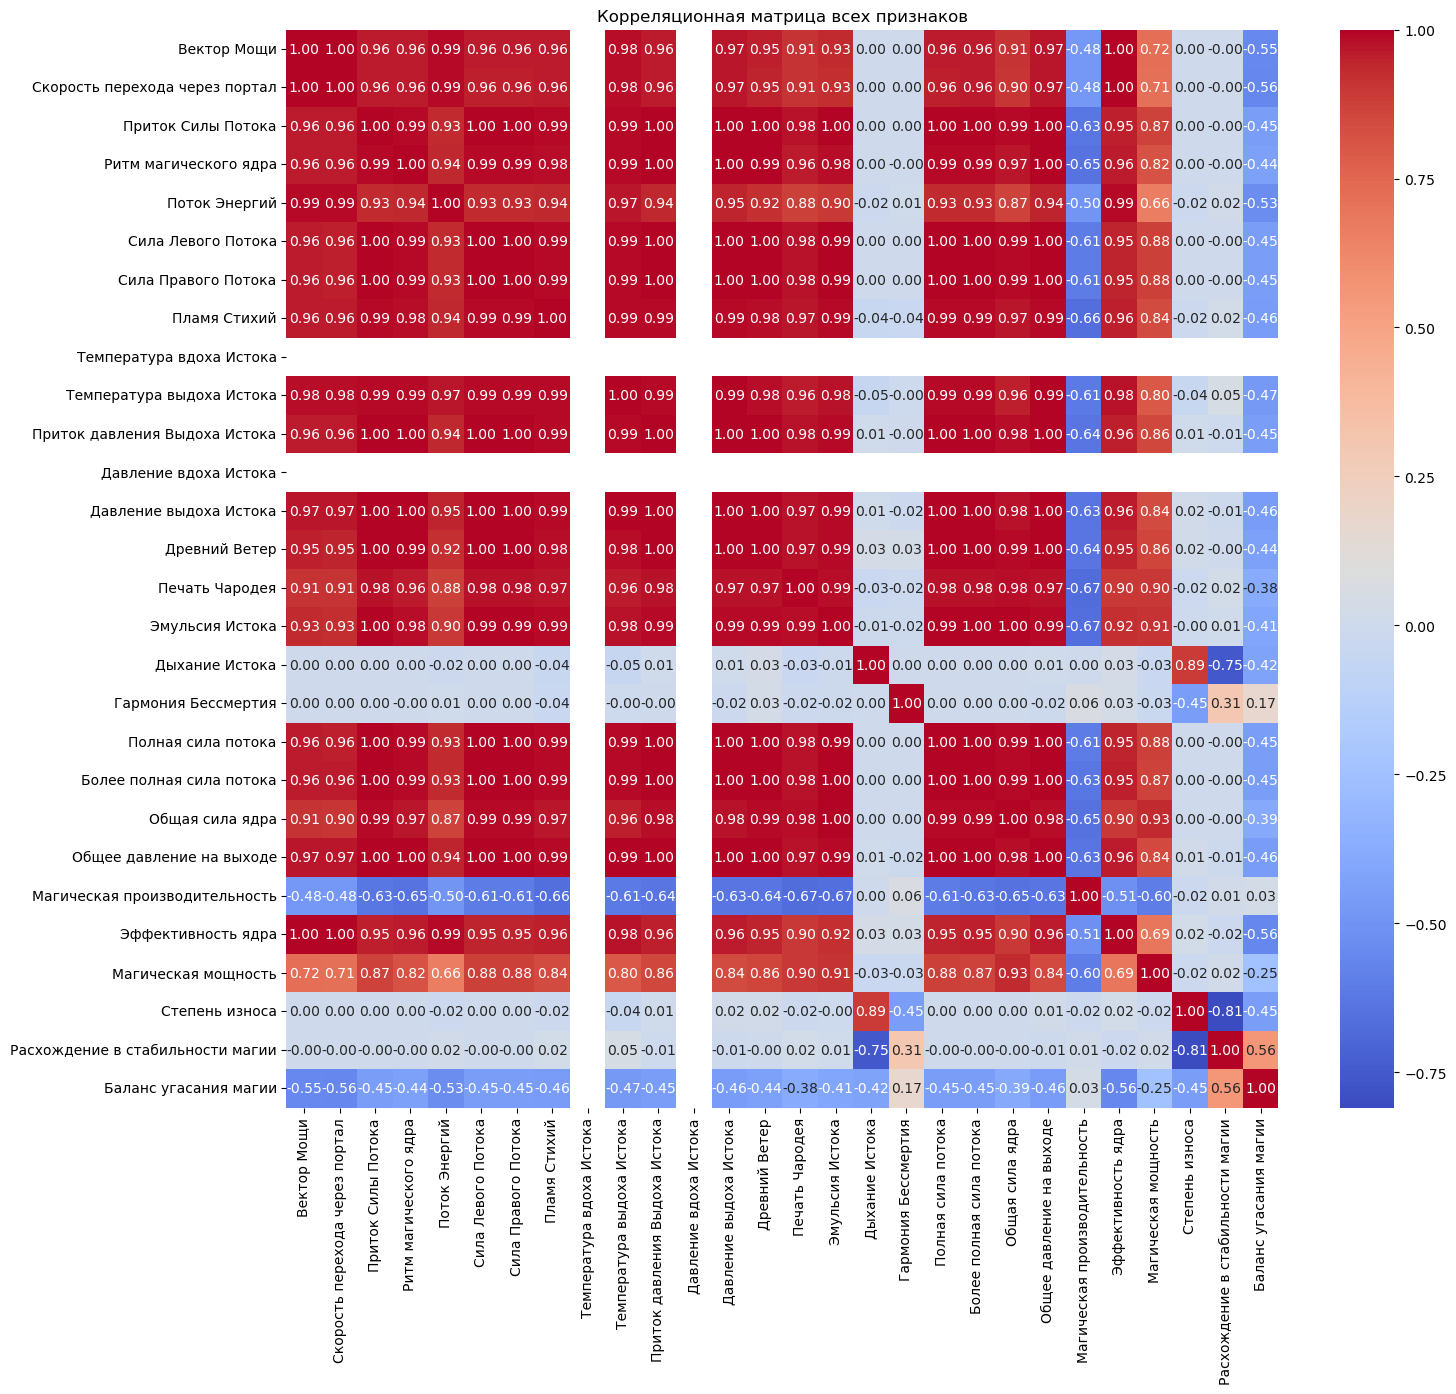

In [23]:
plt.figure(figsize=(16, 14))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Корреляционная матрица всех признаков")
plt.show()

### Убираем признаки, не влияющие на предсказание

In [24]:
# columns_to_drop = ['Сила Левого Потока', 'Сила Правого Потока']
columns_to_drop = ['Сила Левого Потока', 'Сила Правого Потока', 'Температура вдоха Истока', 'Давление вдоха Истока']
df = df.drop(columns=columns_to_drop)

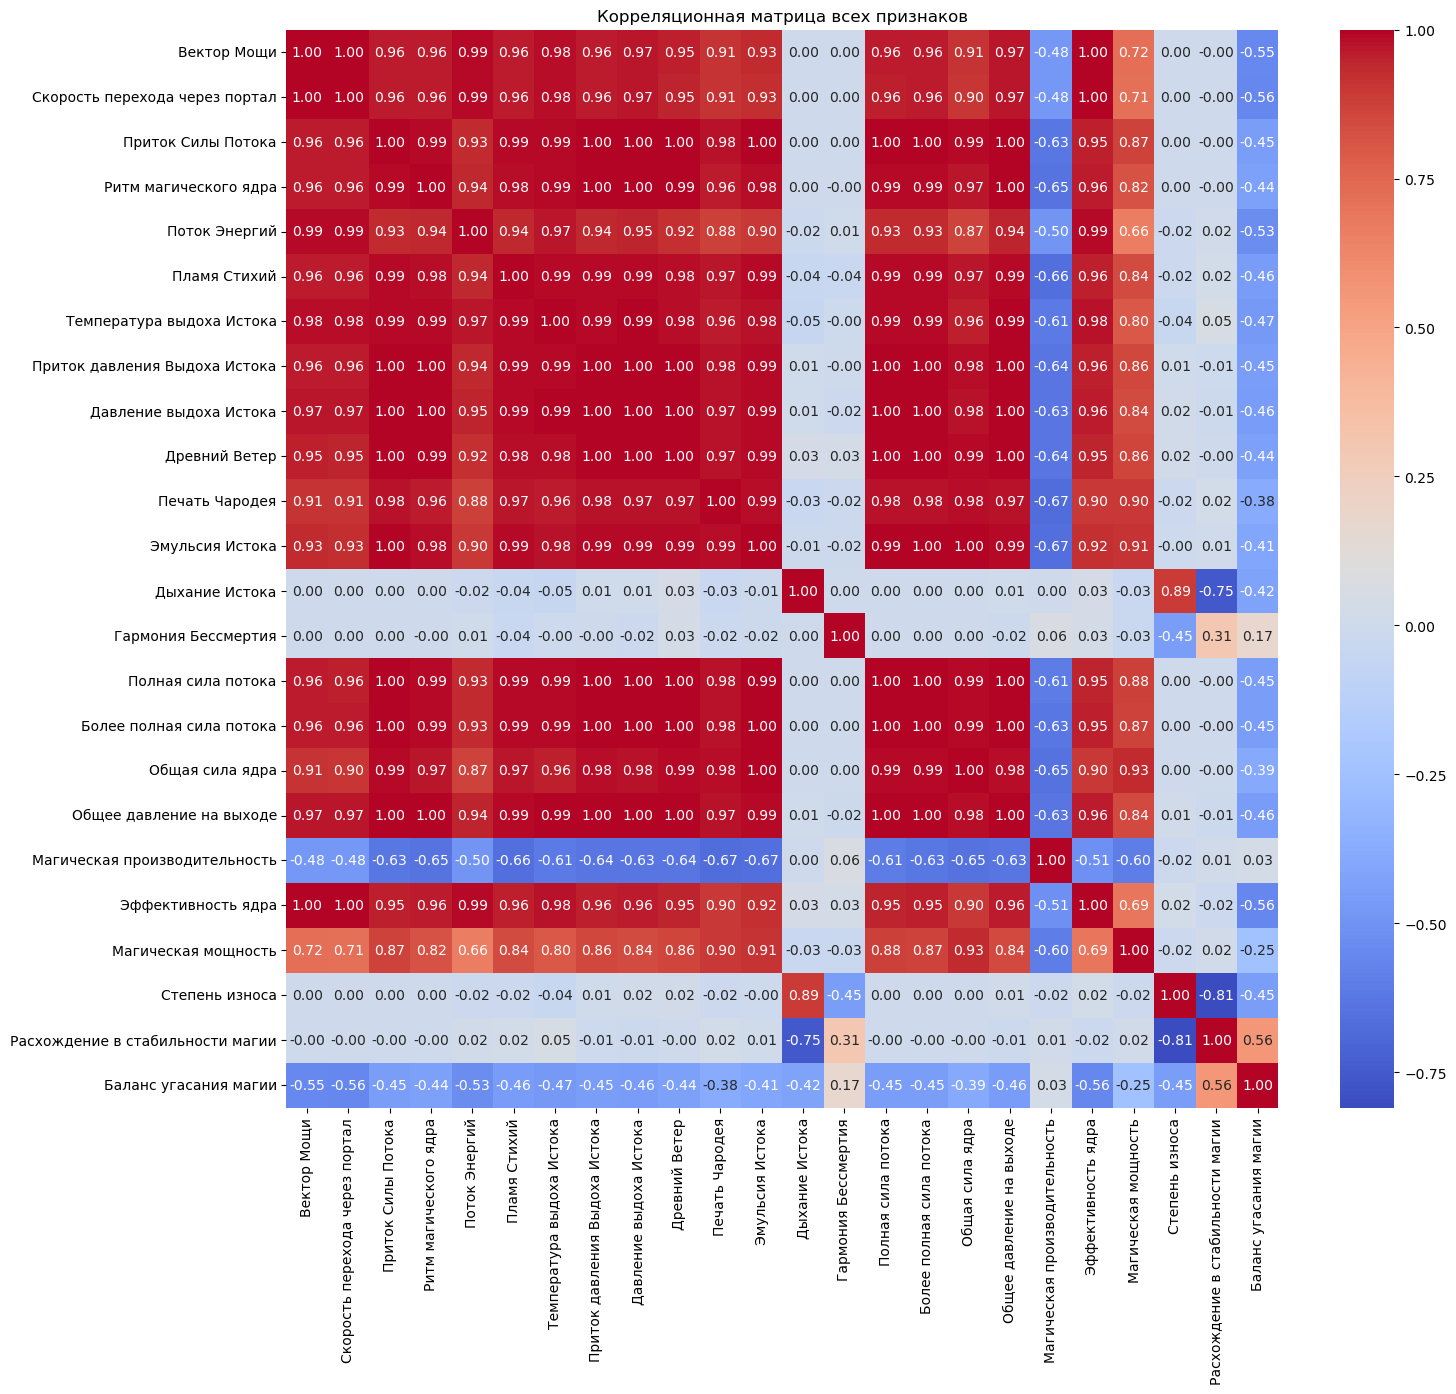

In [25]:
plt.figure(figsize=(16, 14))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Корреляционная матрица всех признаков")
plt.show()

Я убрал признаки Сила Левого Потока, Сила Правого Потока - так как у нас уже есть их сумма и отдельные значения нам не нужны. Температура вдоха Истока, Давление вдоха Истока состоят из одного значения, поэтому их можно опустить

### Графики

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x

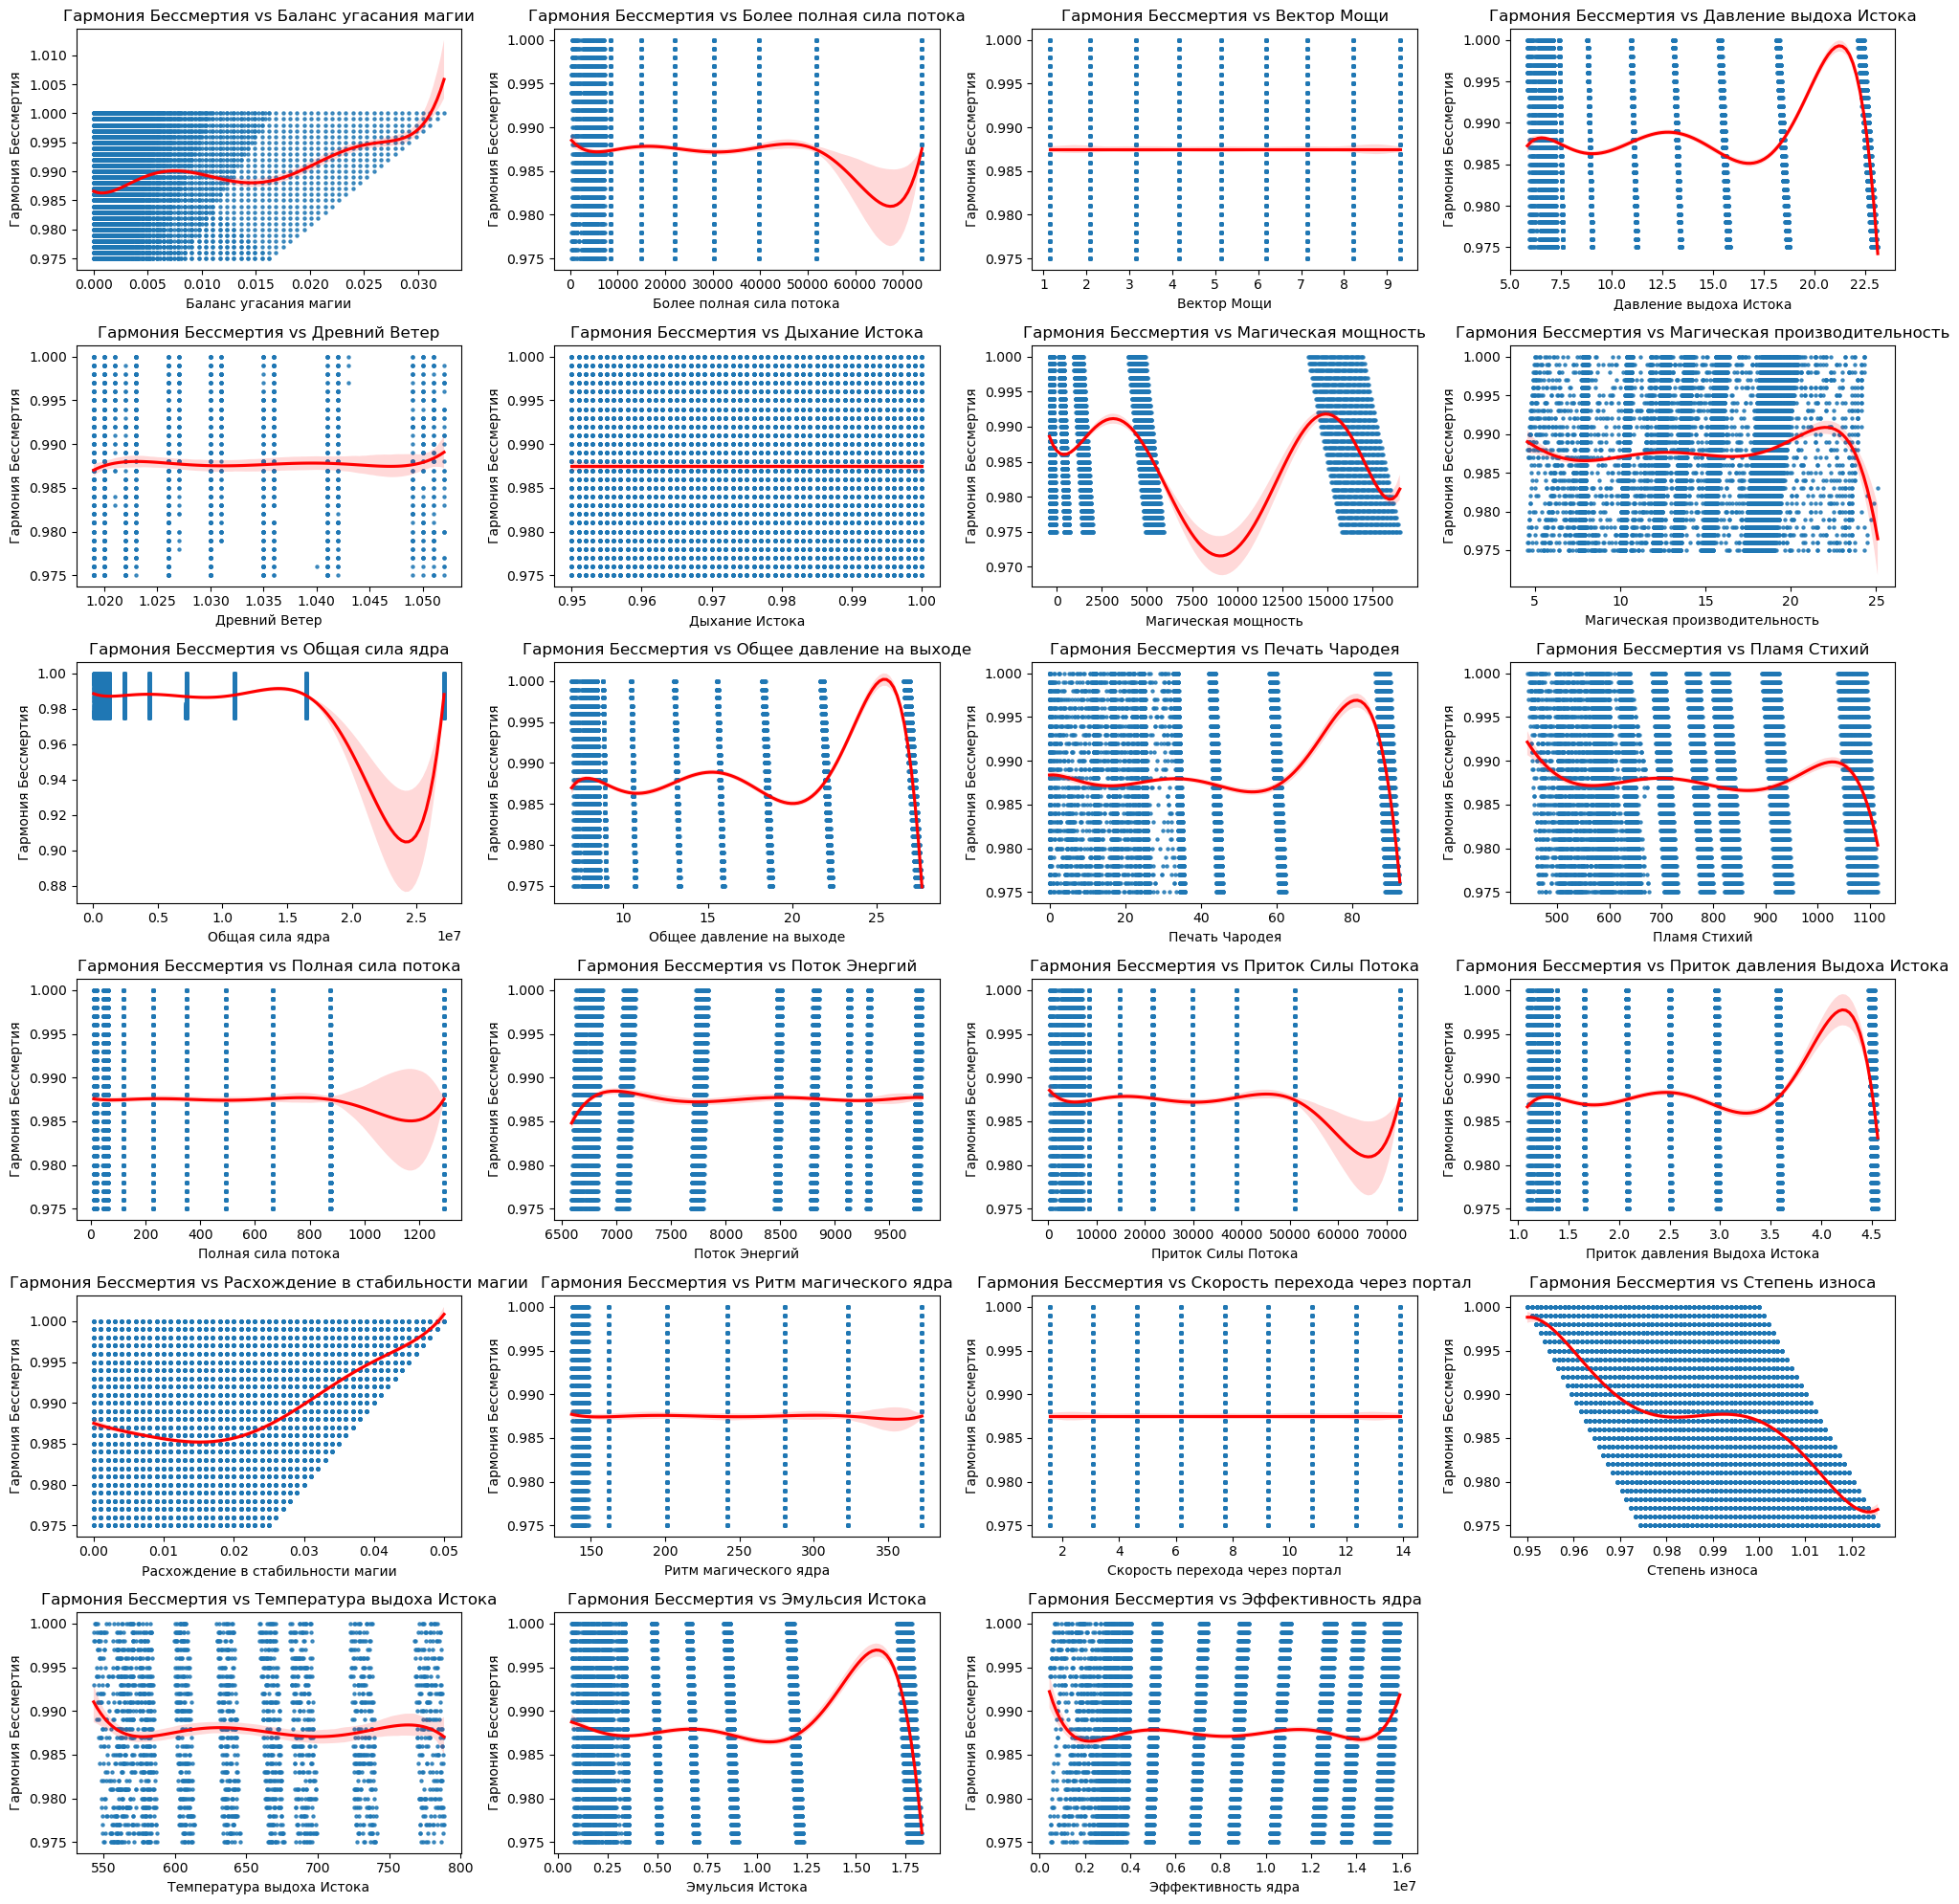

In [ ]:
plt.figure(figsize=(20, 20))
batch_1_features = df.columns.difference(['Гармония Бессмертия'])[:24]

for i, feature in enumerate(batch_1_features, 1):
    plt.subplot(6, 4, i)
    sns.regplot(x=df[feature], y=df['Гармония Бессмертия'], scatter_kws={'s':5}, line_kws={"color": "red"}, order=6)
    plt.title(f"Гармония Бессмертия vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("Гармония Бессмертия")

plt.tight_layout()
plt.show()


Как мы видим, взаимосвязь везде нелинейная, поэтому я буду использовать модели нелинейной зависимости

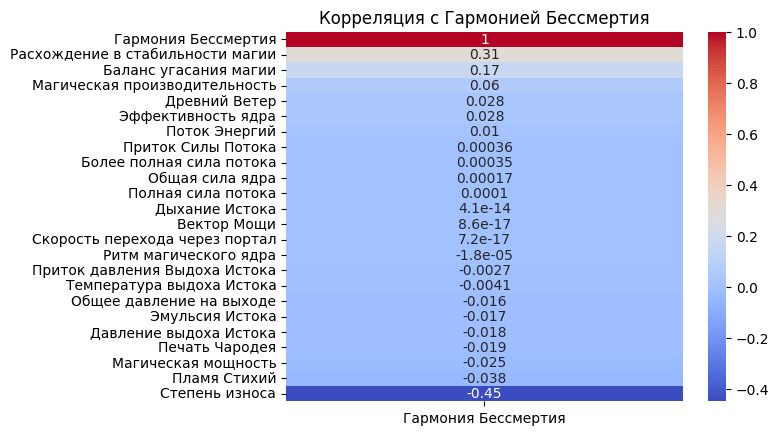

In [72]:
from sklearn.preprocessing import StandardScaler

corr = df.corr()
sns.heatmap(corr[['Гармония Бессмертия']].sort_values(by='Гармония Бессмертия', ascending=False), annot=True, cmap='coolwarm')
plt.title("Корреляция с Гармонией Бессмертия")
plt.show()

Из корреляционной матрицы и по поведению полиномальной линии (с 6 коэффициентами) на графиках, можно определить: 

1. **Баланс угасания магии**: Полиномиальная линия показывает рост Гармонии Бессмертия при увеличении Баланса угасания магии. Это говорит о том, что балансирование угасания магии имеет положительное влияние на стабильность портала.

2. **Более полная сила потока**: Полиномиальная линия здесь более сложная, с некоторыми колебаниями. Это может означать, что связь между этим параметром и Гармонией Бессмертия нелинейная, возможно, существует оптимальный диапазон силы потока, при котором Гармония достигает максимума, но при дальнейшем увеличении эффект может изменяться.

3. **Магическая мощность**: График демонстрирует вогнутую полиномиальную зависимость, что указывает на возможное наличие оптимального уровня магической мощности, при котором достигается наибольшая Гармония. При отклонениях от этого уровня Гармония может снижаться.

4. **Магическая производительность**: Полиномиальная линия идет вниз, показывая отрицательную зависимость, то есть увеличение магической производительности может снижать Гармонию. Это важно учитывать, так как слишком высокие уровни магической производительности могут негативно сказаться на портале.

5. **Печать Чародея** и **Пламя Стихий**: Плавные изменения на графиках говорят о слабом влиянии этих параметров на Гармонию, но с некоторыми небольшими нелинейными эффектами.

6. **Степень износа**: Линия показывает чёткое снижение Гармонии по мере увеличения степени износа, что логично, так как износ напрямую ухудшает состояние портала.

7. **Температура и Давление выдоха Истока**: Зависимость от температуры и давления на выдохе Истока показывает интересные нелинейные колебания, указывая, что эти параметры могут оказывать периодическое влияние на Гармонию.

8. **Расхождение в стабильности магии**: Видно, что с ростом этого параметра Гармония также возрастает. Это может указывать на то, что увеличение стабильности магии позитивно сказывается на состоянии портала.

9. **Большинство параметров**: таких как Скорость перехода через портал, Приток Силы Потока, Общая сила ядра, Вектор Мощи и др., имеют значения корреляции, близкие к нулю. Это говорит о том, что они практически не влияют на "Гармонию Бессмертия". Их влияние, возможно, несущественно для прогнозирования состояния портала.

### Также можно выбрать наиболее влиятельные признаки автоматически 
Но мы не знаем, сколько из них было самых влиятельны, поэтому был необходим предыдущий анализ

In [ ]:
from sklearn.feature_selection import RFE

rf_for_rfe = RandomForestRegressor(n_estimators=300, max_depth=50, random_state=42)
selector = RFE(rf_for_rfe, n_features_to_select=6, step=1)
selector = selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.support_]

print("Selected features:", selected_features)


Selected features: Index(['Ритм магического ядра', 'Температура выдоха Истока', 'Печать Чародея',
       'Дыхание Истока', 'Магическая производительность', 'Эффективность ядра',
       'Магическая мощность', 'Степень износа',
       'Расхождение в стабильности магии', 'Баланс угасания магии'],
      dtype='object')


### Модели

Из-за нелинейной зависимости переменных было принято решение использовать модели с нелинейной зависимость

### Обучаем модели (Random forest, Gradient boost и Extreme Boost)

### 1. **Random Forest**
   - **Сильные стороны**: Random Forest – это ансамбль деревьев решений, который объединяет их предсказания, что делает модель устойчивой к шуму и снижает вероятность переобучения. Она также хорошо работает с разными типами данных и обрабатывает нелинейные зависимости.
   - **Преимущества**: Модель устойчива к выбросам и менее склонна к переобучению по сравнению с обычными деревьями решений, так как используется ансамбль деревьев, построенных на разных подмножествах данных и признаков.

### 2. **Gradient Boosting**
   - **Сильные стороны**: Gradient Boosting строит деревья последовательно, обучая каждое следующее дерево на ошибках предыдущего. Это позволяет модели быть очень точной и выделять значимые зависимости.
   - **Преимущества**: Gradient Boosting часто показывает хорошую точность, но может быть склонен к переобучению, особенно если не настроены гиперпараметры. Поэтому для него важно использовать кросс-валидацию и подбор параметров, как это сделано в коде.

### 3. **XGBoost**
   - **Сильные стороны**: XGBoost – это улучшенная версия Gradient Boosting, оптимизированная для высокой производительности и работы с большими данными. Она включает в себя множество оптимизаций, таких как регуляризация, которая снижает риск переобучения.
   - **Преимущества**: XGBoost – одна из самых популярных и мощных моделей для задач прогнозирования благодаря своей точности и гибкости. Она особенно полезна в задачах, где требуется высокая точность и сложные взаимодействия между признаками.

### Почему не были использованы другие модели?
   - **Линейные модели**: Линейные модели, такие как линейная регрессия или Ridge/Lasso, не были выбраны, так как они предполагают линейные зависимости между признаками и целевой переменной. В данном случае, задача, вероятно, имеет нелинейные зависимости, что требует более сложных моделей.
   - **Простые деревья решений**: Они менее устойчивы к переобучению и, как правило, менее точны, чем ансамбли, такие как Random Forest или Gradient Boosting, особенно на сложных данных.
   - **Методы, не работающие с нелинейностями**: Модели, не учитывающие сложные нелинейности, не смогут эффективно справиться с особенностями данной задачи, поскольку данные имеют сложные взаимодействия между параметрами.

### Для обучения модели были выбраны метрики **RMSE** (корень из средней квадратичной ошибки) и **R²** (коэффициент детерминации)

### 1. Почему RMSE?
   - **Чувствительность к крупным ошибкам**: RMSE учитывает квадрат ошибки, что делает эту метрику чувствительной к крупным ошибкам. Это важно в задачах, где большие ошибки нежелательны и необходимо минимизировать отклонения. Если предсказание сильно отличается от реального значения, RMSE "накажет" модель сильнее, чем метрика, например, MAE (средняя абсолютная ошибка).
   - **Интерпретация в единицах измерения**: RMSE интерпретируется в тех же единицах, что и целевая переменная, то есть в "единицах Гармонии Бессмертия". Это делает RMSE легко интерпретируемой – если RMSE, скажем, 0.1, это значит, что средняя ошибка предсказания составляет 0.1 от значения Гармонии.

### 2. Почему R²?
   - **Оценка объясненной дисперсии**: R² показывает долю дисперсии целевой переменной, объясненную моделью. Это хороший показатель того, насколько модель приближает данные к реальности. Например, R²=0.99 означает, что модель объясняет 99% вариации в данных, что говорит о высоком качестве модели.
   - **Понятность для пользователей**: Многие специалисты привыкли к метрике R², поскольку она часто используется в регрессионном анализе (например в Excel). Это делает её удобной для интерпретации и позволяет пользователям понять качество модели, даже если они не специалисты в машинном обучении.

### Почему не MSE, MAE и т.д.?
- **MSE** (среднеквадратичная ошибка): Хотя MSE и RMSE тесно связаны, RMSE проще интерпретировать, так как результат находится в тех же единицах, что и целевая переменная.
- **MAE** (средняя абсолютная ошибка): MAE учитывает только абсолютные значения ошибок, но не делает различий между большими и маленькими ошибками. В задачах, где важны даже небольшие отклонения, как в данном случае, RMSE предпочтительнее, так как крупные ошибки наказываются сильнее.
- **MAPE** (средняя абсолютная процентная ошибка): Подходит для ситуаций, где нужно понять ошибку в процентах от истинного значения, но MAPE плохо справляется с нулевыми значениями и не подходит для данных с широким диапазоном значений.

### Также была проведена кросс-валидация. Зачем?

### 1. **Оценка стабильности и обобщающей способности модели**
   - Кросс-валидация позволяет оценить, как модель будет работать на новых данных, которых она не видела. Вместо оценки на единственном тестовом наборе данных, модель тестируется на нескольких "поднаборах", что позволяет лучше понять её обобщающую способность.
   - Если модель показывает стабильные результаты на всех "поднаборах", это говорит о том, что она будет хорошо работать на новых данных, а не только на конкретном тестовом наборе, что делает её более надежной.

### 2. **Минимизация переобучения и недообучения**
   - В случае сложных данных, особенно с высоким числом признаков, модель может склоняться к переобучению или недообучению. Кросс-валидация помогает обнаружить это, так как каждый "поднабор" данных проверяет модель на её способность подстраиваться под новые данные.
   - Если модель работает хорошо на одних наборах и плохо на других, это может указывать на переобучение, и кросс-валидация позволяет выявить такие ситуации до использования модели в реальных условиях.

### 3. **Распределение ошибок и их интерпретация**
   - Кросс-валидация показывает распределение ошибок по различным наборам данных. Мы можем получить среднюю и стандартное отклонение ошибок (например, RMSE), что дает представление о вариативности модели. Если стандартное отклонение низкое, это указывает на стабильность модели. Если высокое – на непостоянство результатов, что может указывать на необходимость доработки.

In [ ]:
x = df.drop(columns=['Гармония Бессмертия'])
y = df['Гармония Бессмертия'] #определяем таргетный признак

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42) #делим датасет на тестовый и таргетный

best_models = {}
metrics = {}

def calculate_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 50],
    'min_samples_split': [1, 2]
}
rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1) #Здесь и в дальнейшем подбирает наболее подходящие параметры для моделирования на основе метрики MSE
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
best_models['Random Forest'] = best_rf
metrics['Random Forest'] = calculate_metrics(best_rf, X_test, y_test)

'''
RMSE: 3.303473256274607e-05
R2 Score: 0.9999807658572616
'''

gb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 3, 5],
    'learning_rate': [0.01, 0.1]
}
gb = GradientBoostingRegressor(random_state=42)
gb_grid = GridSearchCV(gb, gb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_
best_models['Gradient Boosting'] = best_gb
metrics['Gradient Boosting'] = calculate_metrics(best_gb, X_test, y_test)

'''
RMSE: 9.758565078519735e-05
R2 Score: 0.9998321570246824
'''

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb = XGBRegressor(tree_method='gpu_hist', random_state=42)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_
best_models['XGBoost'] = best_xgb
metrics['XGBoost'] = calculate_metrics(best_xgb, X_test, y_test)

'''
RMSE: 0.00014024698796766123
R2 Score: 0.9996533283481589
'''

for model_name, (rmse, r2) in metrics.items():
    print(f"Модель: {model_name}")
    print(f"Лучшие параметры: {best_models[model_name].get_params()}")
    print(f"RMSE: {rmse}")
    print(f"R2 Score: {r2}")
    print("-" * 30)

cv_results = {}

for model_name, model in best_models.items():
    rmse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=1)
    mean_rmse = -rmse_scores.mean()
    std_rmse = rmse_scores.std()
    cv_results[model_name] = {'mean_rmse': mean_rmse, 'std_rmse': std_rmse}

cv_results

'''
Самыми точными вышли модели Random forest и XGBoost, будем использовать их и оптимизировать вычисление модели
'''


### Random Forest

Эта модель показала наибольшую точность из подборки, поэтому если важна точность, то можно рекомендуем эту модель

In [ ]:
# x = df.drop(columns=['Гармония Бессмертия']) 
y = df['Гармония Бессмертия']
x = df[['Ритм магического ядра', 'Температура выдоха Истока', 'Печать Чародея',
       'Дыхание Истока', 'Магическая производительность', 'Эффективность ядра',
       'Магическая мощность', 'Степень износа',
       'Расхождение в стабильности магии', 'Баланс угасания магии']] #берем параметры, который оказали наибольшее влияние
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

def calculate_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

rf_params = {
    'n_estimators': [300], #параметры, которые показали наибольшую точность при обучении модели
    'max_depth': [50],
    'min_samples_split': [2]
}
rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
rmse, r2 = calculate_metrics(best_rf, X_test, y_test)

print(f"Модель: Random Forest Regressor")
print(f"Лучшие параметры: {best_rf}")
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

rmse_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=1) #кросс валидация
mean_rmse = -rmse_scores.mean()
std_rmse = rmse_scores.std()
cv_results = {'mean_rmse': mean_rmse, 'std_rmse': std_rmse}

Модель: Random Forest Regressor
Лучшие параметры: RandomForestRegressor(max_depth=50, n_estimators=300, random_state=42)
RMSE: 8.765077566833905e-05
R2 Score: 0.9998645924838644


'\nрекомендациями и удаляя 4 признака\nRMSE: 9.059203127984023e-05\nR2 Score: 0.9998553523976023\n49.4\nрекомендациями и удаляя 2 признака\nRMSE: 9.087687056464593e-05\nR2 Score: 0.9998544413662106\n50.1\n\nБез рекомендаций и удаляя 4 признака\nRMSE: 0.0006102106485379175\nR2 Score: 0.9934371752347085\n33.3\nБез рекомендаций и удаляя 2 признака\nRMSE: 0.000612844979787949\nR2 Score: 0.9933803883769092\n33.8\n'

### Extreme boost, почему я все же рекомендовал его?

XGBoost библеотека благодаря интерграции с CUDA (программно-аппаратная архитектура параллельных вычислений) позволяет проводить вычисления параллельно на GPU, в отличие от расчетов на CPU в Random Forest. Поэтому здесь используется другая библеотека CuPy, которая аналогично знаменитой Numpy, по позволяет хранить данные на GPU, а сами же вычисления производятся на GPU. Также эта модель показала хорошую точность по метрикам тоже. 

In [ ]:
x = df.drop(columns=['Гармония Бессмертия']) 
y = df['Гармония Бессмертия']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

X_train_cupy = cp.array(X_train)#переносим все данные на GPU 
X_test_cupy = cp.array(X_test)
y_train_cupy = cp.array(y_train)
y_test_cupy = cp.array(y_test)

def calculate_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2


xgb_params = {
    'n_estimators': [300],
    'max_depth': [7],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [1.0]
}
xgb = XGBRegressor(tree_method='hist', device='cuda', random_state=42) #подключение вычислений с cuda
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train_cupy, y_train_cupy)
best_xgb = xgb_grid.best_estimator_
rmse, r2 = calculate_metrics(best_xgb, X_test_cupy, y_test_cupy)

'''
Без рекомендаций и удаляя 2 признака
RMSE: 0.0006705690705590026
R2 Score: 0.992074653109041
11.6

С рекомендациями и удаляя 2 признака
RMSE: 0.00020286952170594578
R2 Score: 0.9992746212066436
3.9
'''

rmse_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=1) #кросс валидация
mean_rmse = -rmse_scores.mean()
std_rmse = rmse_scores.std()
cv_results = {'mean_rmse': mean_rmse, 'std_rmse': std_rmse}

print(f"Модель: XGBRegressor")
print(f"Лучшие параметры: {best_xgb}")
# params_df = pd.DataFrame(list(best_xgb.get_params().items()), columns=['Parameter', 'Value'])
# print(params_df)
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

NameError: name 'cp' is not defined

Благодаря параллельным вычислениям на моей машине расчет с  **49** секунд на Random forest уменьшился до **11** секунд на XGBoost, без большой потери в точности

Поэтому я все же рекомендую по возможности использовать XGBoost и другие библиотеки с поддержкой параллельный вычислений на GPU 